# Sentiment Analysis Comparison: Three Models

This notebook compares three sentiment analysis approaches on Ethereum Reddit posts:
1. **FinBERT** - Fine-tuned on financial news (baseline)
2. **DistilBERT Reddit Crypto** - Fine-tuned specifically on Reddit cryptocurrency discussions
3. **CryptoBERT** - Fine-tuned on cryptocurrency-related text

We'll analyze the same dataset with all three models and compare their predictions.

In [ ]:
# Install dependencies (uncomment if needed)
# !pip install transformers torch pandas numpy matplotlib seaborn tqdm

In [19]:
from __future__ import annotations

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple
from collections import Counter

from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TextClassificationPipeline,
)

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Model configurations
FINBERT_MODEL = "ProsusAI/finbert"
REDDIT_CRYPTO_MODEL = "mwkby/distilbert-base-uncased-sentiment-reddit-crypto"
CRYPTOBERT_MODEL = "ElKulako/cryptobert"

# File paths
CWD = Path.cwd()
DATA_DIR = CWD if CWD.name == "social media" else CWD / "social media"
INPUT_CSV = DATA_DIR / "ETH_2024-10_2025-09.csv"
OUTPUT_CSV = DATA_DIR / "ETH_sentiment_comparison.csv"

# Model parameters (CPU only)
MAX_LENGTH = 512
DEVICE = -1  # Force CPU

print(f"Data directory: {DATA_DIR}")
print(f"Input file: {INPUT_CSV}")
print(f"Using CPU for inference")


Data directory: c:\Users\User\text_mining_crypto_FG_index\social media
Input file: c:\Users\User\text_mining_crypto_FG_index\social media\ETH_2024-10_2025-09.csv
Using CPU for inference


## 1. Load and Prepare Data


In [20]:
df = pd.read_csv(INPUT_CSV)
print(f"Loaded {len(df):,} posts from {INPUT_CSV.name}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nDate range: {df['created_at'].min()} to {df['created_at'].max()}")
df.head()


Loaded 668 posts from ETH_2024-10_2025-09.csv

Columns: ['subreddit', 'id', 'created_at', 'title', 'text', 'author', 'upvotes', 'num_comments', 'url', 'permalink']

Date range: 2024-10-06 12:35:49 to 2025-09-28 19:29:05


,subreddit,id,created_at,title,text,author,upvotes,num_comments,url,permalink
0,ethereum,1molmwx,2025-08-12 21:30:06,"I don't know too much about ethereum, what's t...",Hi guys! I'm kind of an old and bald S&P 500...,IndecisiveEnthusiast,115,116,https://www.reddit.com/r/ethereum/comments/1mo...,https://www.reddit.com/r/ethereum/comments/1mo...
1,ethereum,1iuw5ff,2025-02-21 17:18:07,"The crypto exchange ByBit has been hacked, and...","On Feb. 21, the crypto trading platform state...",OldUniversity9799,794,279,https://www.reddit.com/r/ethereum/comments/1iu...,https://www.reddit.com/r/ethereum/comments/1iu...
2,ethereum,1lwo3zx,2025-07-10 21:00:42,"I know a lot about Bitcoin (not nerd level, bu...",....excited. Ethereum can change everything. I...,Nick_Charma,327,83,https://www.reddit.com/r/ethereum/comments/1lw...,https://www.reddit.com/r/ethereum/comments/1lw...
3,ethereum,1k11vtj,2025-04-17 02:11:04,Let's end the FUD around Ethereum.,1. Ethereum has the largest on chain revenue. ...,emperordas,288,117,https://www.reddit.com/r/ethereum/comments/1k1...,https://www.reddit.com/r/ethereum/comments/1k1...
4,ethereum,1khr5ey,2025-05-08 14:14:00,ETH is a store of value and scaling Ethereum w...,"As we scale on L1 and L2, there's a couple thi...",hanniabu,282,69,https://www.reddit.com/r/ethereum/comments/1kh...,https://www.reddit.com/r/ethereum/comments/1kh...


In [21]:
# Combine title and text for sentiment analysis
df["title"] = df["title"].fillna("").astype(str)
df["text"] = df["text"].fillna("").astype(str)
df["combined_text"] = (df["title"].str.strip() + ". " + df["text"].str.strip()).str.strip()
df["combined_text"] = df["combined_text"].str.replace(r"^\. ", "", regex=True)

# Convert created_at to datetime
df["created_at"] = pd.to_datetime(df["created_at"])
df["date"] = df["created_at"].dt.date

print(f"Average text length: {df['combined_text'].str.len().mean():.0f} characters")
print(f"Median text length: {df['combined_text'].str.len().median():.0f} characters")


Average text length: 534 characters
Median text length: 218 characters


## 2. Helper Functions


In [33]:
def chunk_text(
    text: str,
    tokenizer: AutoTokenizer,
    max_length: int = MAX_LENGTH,
    stride: int = 50,
) -> List[str]:
    """Split text into overlapping chunks for long posts."""
    if not text or not text.strip():
        return []

    token_ids = tokenizer.encode(text, add_special_tokens=False)
    if not token_ids:
        return []

    chunk_size = max_length - 2  # reserve space for special tokens
    if chunk_size <= 0:
        chunk_size = max_length

    step = max(1, chunk_size - stride)
    chunks: List[str] = []

    for start in range(0, len(token_ids), step):
        end = start + chunk_size
        ids_slice = token_ids[start:end]
        if not ids_slice:
            break
        chunks.append(tokenizer.decode(ids_slice, skip_special_tokens=True))
        if end >= len(token_ids):
            break

    return chunks or [tokenizer.decode(token_ids, skip_special_tokens=True)]


def score_text(
    text: str,
    pipeline: TextClassificationPipeline,
    tokenizer: AutoTokenizer,
    label_map: Dict[str, str],
    max_length: int = MAX_LENGTH,
) -> Dict[str, float]:
    """Average sentiment probabilities across chunks and normalize labels."""
    chunks = chunk_text(text, tokenizer, max_length=max_length)
    if not chunks:
        return {
            "label": "neutral",
            "confidence": 0.33,
            "prob_negative": 0.33,
            "prob_neutral": 0.34,
            "prob_positive": 0.33,
        }

    outputs = pipeline(chunks, truncation=True, max_length=max_length)
    if isinstance(outputs, dict):
        outputs = [outputs]

    # Aggregate scores across chunks
    score_dict = {"negative": [], "neutral": [], "positive": []}
    
    for result in outputs:
        if isinstance(result, list):
            # return_all_scores=True
            for entry in result:
                mapped_label = label_map.get(entry["label"].lower(), entry["label"].lower())
                if mapped_label in score_dict:
                    score_dict[mapped_label].append(entry["score"])
        else:
            # Single prediction
            mapped_label = label_map.get(result["label"].lower(), result["label"].lower())
            if mapped_label in score_dict:
                score_dict[mapped_label].append(result["score"])

    # Average scores
    avg_scores = {
        k: np.mean(v) if v else 0.0 
        for k, v in score_dict.items()
    }
    
    # Find best label
    best_label = max(avg_scores, key=avg_scores.get)
    
    return {
        "label": best_label,
        "confidence": float(avg_scores[best_label]),
        "prob_negative": float(avg_scores["negative"]),
        "prob_neutral": float(avg_scores["neutral"]),
        "prob_positive": float(avg_scores["positive"]),
        "sentiment_score": float(avg_scores["positive"] - avg_scores["negative"]),
    }


def load_model_pipeline(model_name: str, device: int) -> Tuple[TextClassificationPipeline, Dict[str, str]]:
    """Load a sentiment model and return pipeline + label mapping."""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    
    pipeline = TextClassificationPipeline(
        model=model,
        tokenizer=tokenizer,
        return_all_scores=True,
        device=device,
    )
    
    # Label mapping to standardize outputs to positive/negative/neutral
    label_map = {}
    if "cryptobert" in model_name.lower():
        # CryptoBERT uses: Bearish, Neutral, Bullish
        label_map = {"bearish": "negative", "neutral": "neutral", "bullish": "positive"}
    elif "finbert" in model_name.lower():
        # FinBERT uses: positive, negative, neutral
        label_map = {"positive": "positive", "negative": "negative", "neutral": "neutral"}
    else:
        # Reddit crypto model and others use standard labels
        label_map = {"positive": "positive", "negative": "negative", "neutral": "neutral"}
    
    return pipeline, label_map


## 3. Run FinBERT Analysis (Baseline)


In [34]:
print(f"Loading {FINBERT_MODEL} on CPU...")

finbert_pipeline, finbert_label_map = load_model_pipeline(FINBERT_MODEL, DEVICE)
finbert_tokenizer = finbert_pipeline.tokenizer

print("\nRunning FinBERT sentiment analysis...")
finbert_results: List[Dict[str, float]] = []

for text in tqdm(df["combined_text"], desc="FinBERT", total=len(df)):
    result = score_text(text, finbert_pipeline, finbert_tokenizer, finbert_label_map, max_length=MAX_LENGTH)
    finbert_results.append(result)

# Add results to dataframe
df["finbert_label"] = [r["label"] for r in finbert_results]
df["finbert_confidence"] = [r["confidence"] for r in finbert_results]
df["finbert_prob_neg"] = [r["prob_negative"] for r in finbert_results]
df["finbert_prob_neu"] = [r["prob_neutral"] for r in finbert_results]
df["finbert_prob_pos"] = [r["prob_positive"] for r in finbert_results]
df["finbert_sentiment_score"] = [r["sentiment_score"] for r in finbert_results]

print("\nFinBERT sentiment distribution:")
print(df["finbert_label"].value_counts())
print(f"\nAverage confidence: {df['finbert_confidence'].mean():.4f}")
print(f"Average sentiment score: {df['finbert_sentiment_score'].mean():.4f} (range: -1 to +1)")


Loading ProsusAI/finbert on CPU...


Device set to use cpu



Running FinBERT sentiment analysis...


FinBERT:   0%|          | 0/668 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (633 > 512). Running this sequence through the model will result in indexing errors



FinBERT sentiment distribution:
finbert_label
neutral     499
positive     85
negative     84
Name: count, dtype: int64

Average confidence: 0.8182
Average sentiment score: 0.0211 (range: -1 to +1)


## 4. Run Reddit Crypto Model Analysis


In [35]:
print(f"Loading {REDDIT_CRYPTO_MODEL} on CPU...")

reddit_pipeline, reddit_label_map = load_model_pipeline(REDDIT_CRYPTO_MODEL, DEVICE)
reddit_tokenizer = reddit_pipeline.tokenizer

print("\nRunning Reddit Crypto sentiment analysis...")
reddit_results: List[Dict[str, float]] = []

for text in tqdm(df["combined_text"], desc="Reddit Crypto", total=len(df)):
    result = score_text(text, reddit_pipeline, reddit_tokenizer, reddit_label_map, max_length=MAX_LENGTH)
    reddit_results.append(result)

# Add results to dataframe
df["reddit_label"] = [r["label"] for r in reddit_results]
df["reddit_confidence"] = [r["confidence"] for r in reddit_results]
df["reddit_prob_neg"] = [r["prob_negative"] for r in reddit_results]
df["reddit_prob_neu"] = [r["prob_neutral"] for r in reddit_results]
df["reddit_prob_pos"] = [r["prob_positive"] for r in reddit_results]
df["reddit_sentiment_score"] = [r["sentiment_score"] for r in reddit_results]

print("\nReddit Crypto sentiment distribution:")
print(df["reddit_label"].value_counts())
print(f"\nAverage confidence: {df['reddit_confidence'].mean():.4f}")
print(f"Average sentiment score: {df['reddit_sentiment_score'].mean():.4f} (range: -1 to +1)")


Loading mwkby/distilbert-base-uncased-sentiment-reddit-crypto on CPU...


Device set to use cpu



Running Reddit Crypto sentiment analysis...


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Reddit Crypto:   0%|          | 0/668 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (633 > 512). Running this sequence through the model will result in indexing errors



Reddit Crypto sentiment distribution:
reddit_label
positive    417
negative    251
Name: count, dtype: int64

Average confidence: 0.9456
Average sentiment score: 0.2373 (range: -1 to +1)


## 5. Run CryptoBERT Analysis


In [36]:
print(f"Loading {CRYPTOBERT_MODEL} on CPU...")

cryptobert_pipeline, cryptobert_label_map = load_model_pipeline(CRYPTOBERT_MODEL, DEVICE)
cryptobert_tokenizer = cryptobert_pipeline.tokenizer

print("\nRunning CryptoBERT sentiment analysis...")
cryptobert_results: List[Dict[str, float]] = []

for text in tqdm(df["combined_text"], desc="CryptoBERT", total=len(df)):
    result = score_text(text, cryptobert_pipeline, cryptobert_tokenizer, cryptobert_label_map, max_length=MAX_LENGTH)
    cryptobert_results.append(result)

# Add results to dataframe
df["cryptobert_label"] = [r["label"] for r in cryptobert_results]
df["cryptobert_confidence"] = [r["confidence"] for r in cryptobert_results]
df["cryptobert_prob_neg"] = [r["prob_negative"] for r in cryptobert_results]
df["cryptobert_prob_neu"] = [r["prob_neutral"] for r in cryptobert_results]
df["cryptobert_prob_pos"] = [r["prob_positive"] for r in cryptobert_results]
df["cryptobert_sentiment_score"] = [r["sentiment_score"] for r in cryptobert_results]

print("\nCryptoBERT sentiment distribution:")
print(df["cryptobert_label"].value_counts())
print(f"\nAverage confidence: {df['cryptobert_confidence'].mean():.4f}")
print(f"Average sentiment score: {df['cryptobert_sentiment_score'].mean():.4f} (range: -1 to +1)")


Loading ElKulako/cryptobert on CPU...


Device set to use cpu



Running CryptoBERT sentiment analysis...


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


CryptoBERT:   0%|          | 0/668 [00:00<?, ?it/s]


CryptoBERT sentiment distribution:
cryptobert_label
positive    344
neutral     274
negative     50
Name: count, dtype: int64

Average confidence: 0.6362
Average sentiment score: 0.3981 (range: -1 to +1)


## 6. Save Results


In [37]:
# Drop temporary combined_text column
df_output = df.drop(columns=["combined_text"])

OUTPUT_CSV.parent.mkdir(parents=True, exist_ok=True)
df_output.to_csv(OUTPUT_CSV, index=False)
print(f"Saved results to {OUTPUT_CSV}")

df.head()


Saved results to c:\Users\User\text_mining_crypto_FG_index\social media\ETH_sentiment_comparison.csv


,subreddit,id,created_at,title,text,author,upvotes,num_comments,url,permalink,...,reddit_prob_neg,reddit_prob_neu,reddit_prob_pos,reddit_sentiment_score,cryptobert_label,cryptobert_confidence,cryptobert_prob_neg,cryptobert_prob_neu,cryptobert_prob_pos,cryptobert_sentiment_score
0,ethereum,1molmwx,2025-08-12 21:30:06,"I don't know too much about ethereum, what's t...",Hi guys! I'm kind of an old and bald S&P 500...,IndecisiveEnthusiast,115,116,https://www.reddit.com/r/ethereum/comments/1mo...,https://www.reddit.com/r/ethereum/comments/1mo...,...,0.908507,0.0,0.091493,-0.817014,positive,0.565643,0.000527,0.433830,0.565643,0.565115
1,ethereum,1iuw5ff,2025-02-21 17:18:07,"The crypto exchange ByBit has been hacked, and...","On Feb. 21, the crypto trading platform state...",OldUniversity9799,794,279,https://www.reddit.com/r/ethereum/comments/1iu...,https://www.reddit.com/r/ethereum/comments/1iu...,...,0.999286,0.0,0.000714,-0.998572,neutral,0.557263,0.131638,0.557263,0.311100,0.179462
2,ethereum,1lwo3zx,2025-07-10 21:00:42,"I know a lot about Bitcoin (not nerd level, bu...",....excited. Ethereum can change everything. I...,Nick_Charma,327,83,https://www.reddit.com/r/ethereum/comments/1lw...,https://www.reddit.com/r/ethereum/comments/1lw...,...,0.002180,0.0,0.997820,0.995640,positive,0.501659,0.063824,0.434517,0.501659,0.437835
3,ethereum,1k11vtj,2025-04-17 02:11:04,Let's end the FUD around Ethereum.,1. Ethereum has the largest on chain revenue. ...,emperordas,288,117,https://www.reddit.com/r/ethereum/comments/1k1...,https://www.reddit.com/r/ethereum/comments/1k1...,...,0.003176,0.0,0.996824,0.993648,neutral,0.595688,0.000082,0.595688,0.404229,0.404147
4,ethereum,1khr5ey,2025-05-08 14:14:00,ETH is a store of value and scaling Ethereum w...,"As we scale on L1 and L2, there's a couple thi...",hanniabu,282,69,https://www.reddit.com/r/ethereum/comments/1kh...,https://www.reddit.com/r/ethereum/comments/1kh...,...,0.002470,0.0,0.997530,0.995059,positive,0.649610,0.000679,0.349711,0.649610,0.648931


## 7. Analysis & Visualization

### 7.1 Model Agreement Analysis


In [38]:
# Calculate agreement between all models
df["finbert_reddit_agree"] = df["finbert_label"] == df["reddit_label"]
df["finbert_cryptobert_agree"] = df["finbert_label"] == df["cryptobert_label"]
df["reddit_cryptobert_agree"] = df["reddit_label"] == df["cryptobert_label"]
df["all_agree"] = (df["finbert_label"] == df["reddit_label"]) & (df["reddit_label"] == df["cryptobert_label"])

print("Model Agreement Rates:")
print(f"  FinBERT ↔ Reddit Crypto: {df['finbert_reddit_agree'].mean():.2%}")
print(f"  FinBERT ↔ CryptoBERT: {df['finbert_cryptobert_agree'].mean():.2%}")
print(f"  Reddit Crypto ↔ CryptoBERT: {df['reddit_cryptobert_agree'].mean():.2%}")
print(f"  All 3 models agree: {df['all_agree'].mean():.2%}")

print(f"\nTotal posts where all 3 agree: {df['all_agree'].sum()} out of {len(df)}")
print(f"At least one disagreement: {(~df['all_agree']).sum()} posts")


Model Agreement Rates:
  FinBERT ↔ Reddit Crypto: 23.35%
  FinBERT ↔ CryptoBERT: 42.66%
  Reddit Crypto ↔ CryptoBERT: 42.07%
  All 3 models agree: 10.93%

Total posts where all 3 agree: 73 out of 668
At least one disagreement: 595 posts


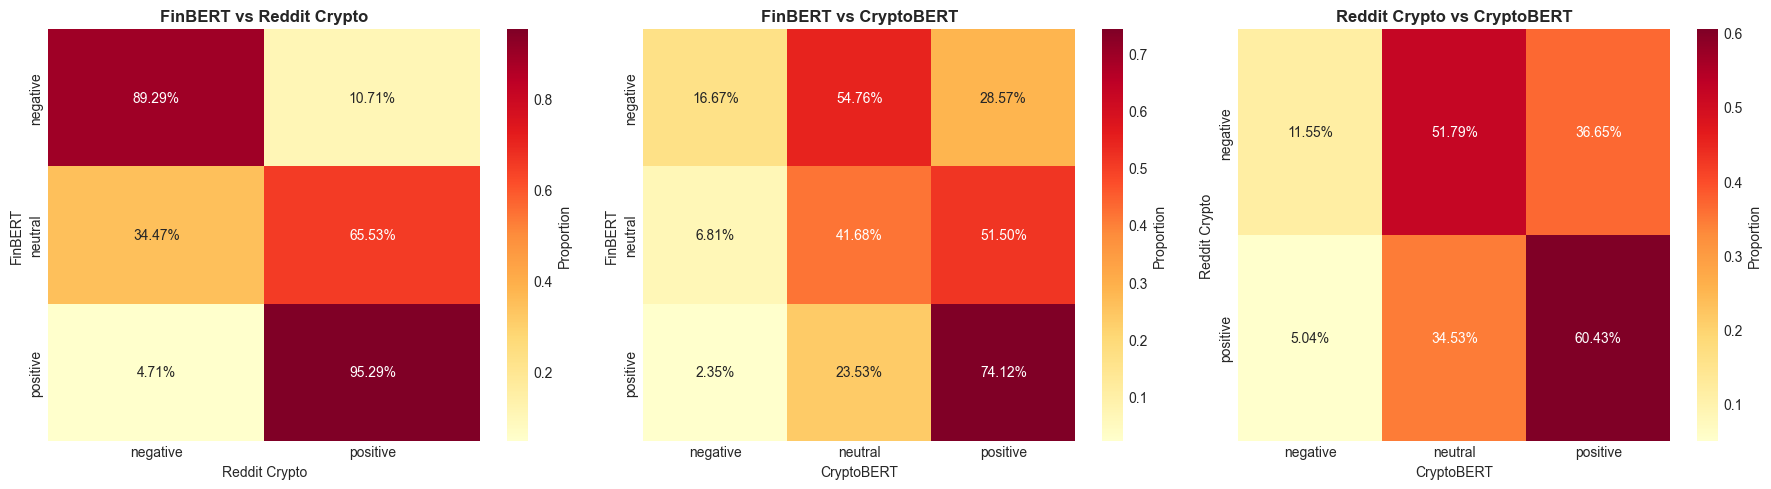


Interpretation: Values show what % of the row model's predictions match the column model's predictions


In [39]:
# Confusion matrices between models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# FinBERT vs Reddit Crypto
confusion1 = pd.crosstab(df["finbert_label"], df["reddit_label"], normalize="index")
sns.heatmap(confusion1, annot=True, fmt=".2%", cmap="YlOrRd", ax=axes[0], cbar_kws={"label": "Proportion"})
axes[0].set_title("FinBERT vs Reddit Crypto", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Reddit Crypto", fontsize=10)
axes[0].set_ylabel("FinBERT", fontsize=10)

# FinBERT vs CryptoBERT
confusion2 = pd.crosstab(df["finbert_label"], df["cryptobert_label"], normalize="index")
sns.heatmap(confusion2, annot=True, fmt=".2%", cmap="YlOrRd", ax=axes[1], cbar_kws={"label": "Proportion"})
axes[1].set_title("FinBERT vs CryptoBERT", fontsize=12, fontweight="bold")
axes[1].set_xlabel("CryptoBERT", fontsize=10)
axes[1].set_ylabel("FinBERT", fontsize=10)

# Reddit Crypto vs CryptoBERT
confusion3 = pd.crosstab(df["reddit_label"], df["cryptobert_label"], normalize="index")
sns.heatmap(confusion3, annot=True, fmt=".2%", cmap="YlOrRd", ax=axes[2], cbar_kws={"label": "Proportion"})
axes[2].set_title("Reddit Crypto vs CryptoBERT", fontsize=12, fontweight="bold")
axes[2].set_xlabel("CryptoBERT", fontsize=10)
axes[2].set_ylabel("Reddit Crypto", fontsize=10)

plt.tight_layout()
plt.show()

print("\nInterpretation: Values show what % of the row model's predictions match the column model's predictions")


### 7.2 Sentiment Distribution Comparison


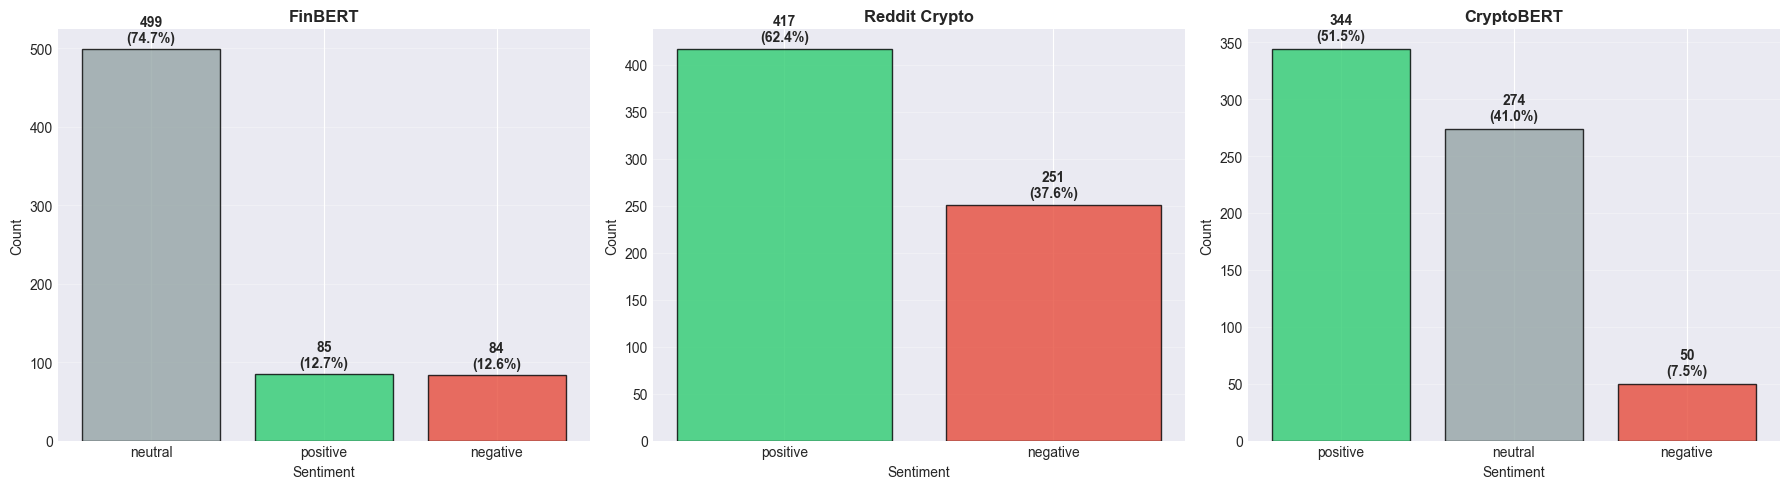

In [40]:
# Compare sentiment distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = {"positive": "#2ecc71", "neutral": "#95a5a6", "negative": "#e74c3c"}

# FinBERT distribution
finbert_counts = df["finbert_label"].value_counts()
finbert_colors = [colors.get(label, "#3498db") for label in finbert_counts.index]
axes[0].bar(finbert_counts.index, finbert_counts.values, color=finbert_colors, alpha=0.8, edgecolor="black")
axes[0].set_title("FinBERT", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Sentiment", fontsize=10)
axes[0].set_ylabel("Count", fontsize=10)
axes[0].grid(axis="y", alpha=0.3)
for i, (label, count) in enumerate(finbert_counts.items()):
    axes[0].text(i, count + 5, f"{count}\n({count/len(df)*100:.1f}%)", 
                ha="center", va="bottom", fontweight="bold")

# Reddit Crypto distribution
reddit_counts = df["reddit_label"].value_counts()
reddit_colors = [colors.get(label, "#3498db") for label in reddit_counts.index]
axes[1].bar(reddit_counts.index, reddit_counts.values, color=reddit_colors, alpha=0.8, edgecolor="black")
axes[1].set_title("Reddit Crypto", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Sentiment", fontsize=10)
axes[1].set_ylabel("Count", fontsize=10)
axes[1].grid(axis="y", alpha=0.3)
for i, (label, count) in enumerate(reddit_counts.items()):
    axes[1].text(i, count + 5, f"{count}\n({count/len(df)*100:.1f}%)", 
                ha="center", va="bottom", fontweight="bold")

# CryptoBERT distribution
cryptobert_counts = df["cryptobert_label"].value_counts()
cryptobert_colors = [colors.get(label, "#3498db") for label in cryptobert_counts.index]
axes[2].bar(cryptobert_counts.index, cryptobert_counts.values, color=cryptobert_colors, alpha=0.8, edgecolor="black")
axes[2].set_title("CryptoBERT", fontsize=12, fontweight="bold")
axes[2].set_xlabel("Sentiment", fontsize=10)
axes[2].set_ylabel("Count", fontsize=10)
axes[2].grid(axis="y", alpha=0.3)
for i, (label, count) in enumerate(cryptobert_counts.items()):
    axes[2].text(i, count + 5, f"{count}\n({count/len(df)*100:.1f}%)", 
                ha="center", va="bottom", fontweight="bold")

plt.tight_layout()
plt.show()


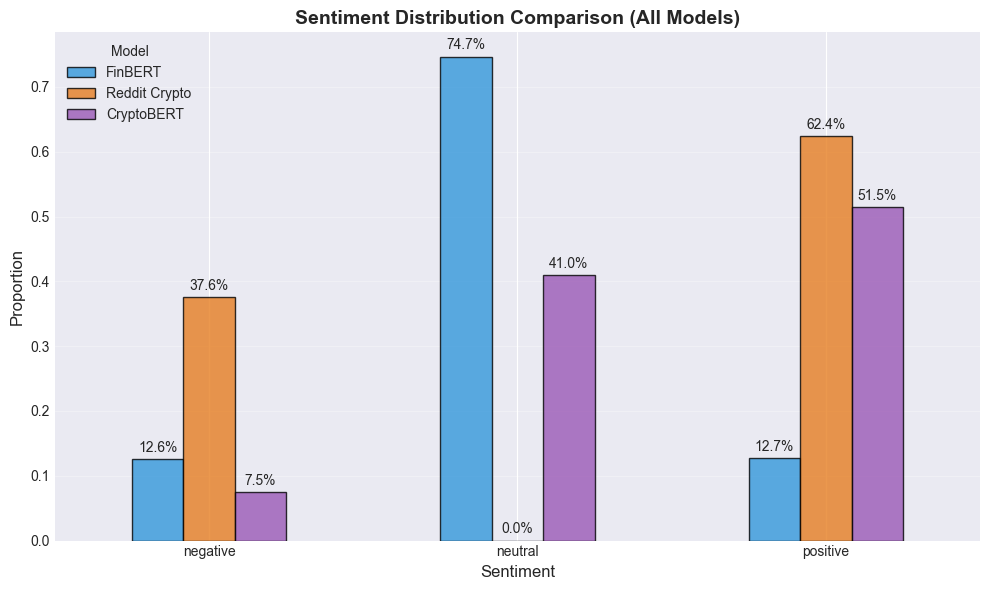

In [42]:
# Side-by-side comparison
comparison_data = pd.DataFrame({
    "FinBERT": df["finbert_label"].value_counts(normalize=True).sort_index(),
    "Reddit Crypto": df["reddit_label"].value_counts(normalize=True).sort_index(),
    "CryptoBERT": df["cryptobert_label"].value_counts(normalize=True).sort_index(),
})

ax = comparison_data.plot(kind="bar", figsize=(10, 6), color=["#3498db", "#e67e22", "#9b59b6"], alpha=0.8, edgecolor="black")
ax.set_title("Sentiment Distribution Comparison (All Models)", fontsize=14, fontweight="bold")
ax.set_xlabel("Sentiment", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title="Model", fontsize=10)
ax.grid(axis="y", alpha=0.3)

# Add percentage labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="edge", padding=3, labels=[f"{v.get_height()*100:.1f}%" for v in container])

plt.tight_layout()
plt.show()


### 7.3 Confidence Score Analysis


Confidence Statistics by Model:

FinBERT:
  Mean: 0.8182
  Median: 0.8705
  Std: 0.1303

Reddit Crypto:
  Mean: 0.9456
  Median: 0.9937
  Std: 0.1099

CryptoBERT:
  Mean: 0.6362
  Median: 0.6188
  Std: 0.1131


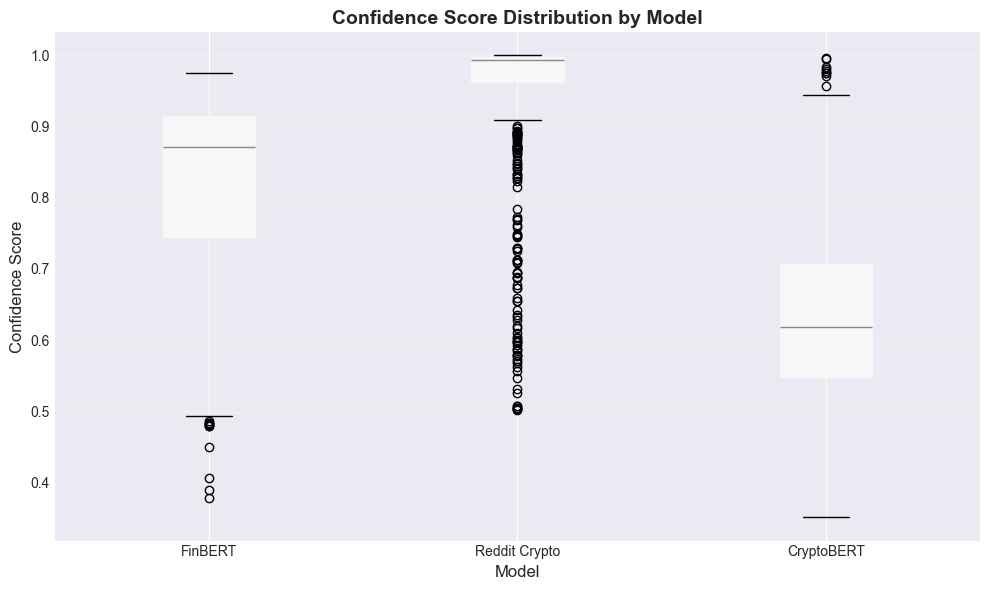

In [43]:
# Confidence statistics by model
print("Confidence Statistics by Model:")
print(f"\nFinBERT:")
print(f"  Mean: {df['finbert_confidence'].mean():.4f}")
print(f"  Median: {df['finbert_confidence'].median():.4f}")
print(f"  Std: {df['finbert_confidence'].std():.4f}")

print(f"\nReddit Crypto:")
print(f"  Mean: {df['reddit_confidence'].mean():.4f}")
print(f"  Median: {df['reddit_confidence'].median():.4f}")
print(f"  Std: {df['reddit_confidence'].std():.4f}")

print(f"\nCryptoBERT:")
print(f"  Mean: {df['cryptobert_confidence'].mean():.4f}")
print(f"  Median: {df['cryptobert_confidence'].median():.4f}")
print(f"  Std: {df['cryptobert_confidence'].std():.4f}")

# Box plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
confidence_data = pd.DataFrame({
    "FinBERT": df["finbert_confidence"],
    "Reddit Crypto": df["reddit_confidence"],
    "CryptoBERT": df["cryptobert_confidence"]
})

confidence_data.boxplot(ax=ax, patch_artist=True)
ax.set_title("Confidence Score Distribution by Model", fontsize=14, fontweight="bold")
ax.set_ylabel("Confidence Score", fontsize=12)
ax.set_xlabel("Model", fontsize=12)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


### 7.4 Continuous Sentiment Score Distribution


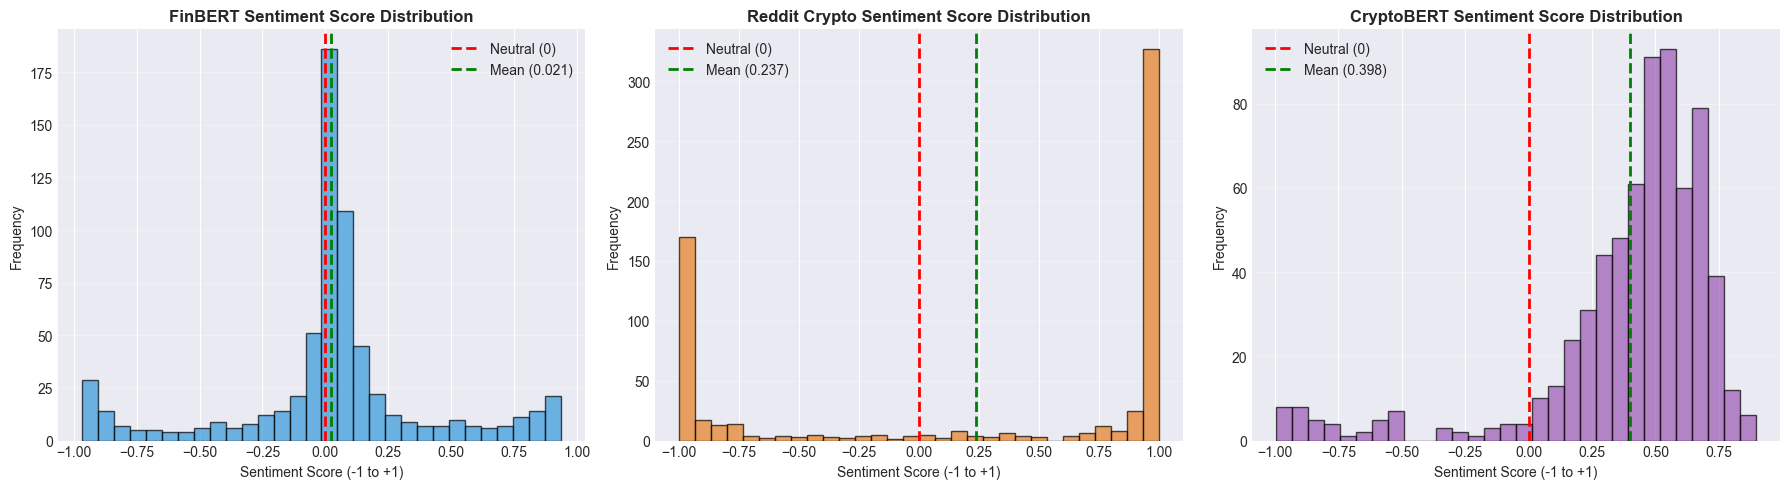


Continuous Sentiment Score Statistics:

FinBERT:
  Mean: 0.0211
  Median: 0.0321
  Std: 0.4016
  Min: -0.9685
  Max: 0.9381

Reddit Crypto:
  Mean: 0.2373
  Median: 0.9156
  Std: 0.8873
  Min: -0.9990
  Max: 0.9984

CryptoBERT:
  Mean: 0.3981
  Median: 0.4890
  Std: 0.3573
  Min: -0.9943
  Max: 0.8965


In [44]:
# Histogram comparison of continuous sentiment scores
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# FinBERT distribution
axes[0].hist(df["finbert_sentiment_score"], bins=30, color="#3498db", alpha=0.7, edgecolor="black")
axes[0].axvline(x=0, color="red", linestyle="--", linewidth=2, label="Neutral (0)")
axes[0].axvline(x=df["finbert_sentiment_score"].mean(), color="green", linestyle="--", linewidth=2, label=f"Mean ({df['finbert_sentiment_score'].mean():.3f})")
axes[0].set_title("FinBERT Sentiment Score Distribution", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Sentiment Score (-1 to +1)", fontsize=10)
axes[0].set_ylabel("Frequency", fontsize=10)
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# Reddit Crypto distribution
axes[1].hist(df["reddit_sentiment_score"], bins=30, color="#e67e22", alpha=0.7, edgecolor="black")
axes[1].axvline(x=0, color="red", linestyle="--", linewidth=2, label="Neutral (0)")
axes[1].axvline(x=df["reddit_sentiment_score"].mean(), color="green", linestyle="--", linewidth=2, label=f"Mean ({df['reddit_sentiment_score'].mean():.3f})")
axes[1].set_title("Reddit Crypto Sentiment Score Distribution", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Sentiment Score (-1 to +1)", fontsize=10)
axes[1].set_ylabel("Frequency", fontsize=10)
axes[1].legend()
axes[1].grid(axis="y", alpha=0.3)

# CryptoBERT distribution
axes[2].hist(df["cryptobert_sentiment_score"], bins=30, color="#9b59b6", alpha=0.7, edgecolor="black")
axes[2].axvline(x=0, color="red", linestyle="--", linewidth=2, label="Neutral (0)")
axes[2].axvline(x=df["cryptobert_sentiment_score"].mean(), color="green", linestyle="--", linewidth=2, label=f"Mean ({df['cryptobert_sentiment_score'].mean():.3f})")
axes[2].set_title("CryptoBERT Sentiment Score Distribution", fontsize=12, fontweight="bold")
axes[2].set_xlabel("Sentiment Score (-1 to +1)", fontsize=10)
axes[2].set_ylabel("Frequency", fontsize=10)
axes[2].legend()
axes[2].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nContinuous Sentiment Score Statistics:")
print(f"\nFinBERT:")
print(f"  Mean: {df['finbert_sentiment_score'].mean():.4f}")
print(f"  Median: {df['finbert_sentiment_score'].median():.4f}")
print(f"  Std: {df['finbert_sentiment_score'].std():.4f}")
print(f"  Min: {df['finbert_sentiment_score'].min():.4f}")
print(f"  Max: {df['finbert_sentiment_score'].max():.4f}")

print(f"\nReddit Crypto:")
print(f"  Mean: {df['reddit_sentiment_score'].mean():.4f}")
print(f"  Median: {df['reddit_sentiment_score'].median():.4f}")
print(f"  Std: {df['reddit_sentiment_score'].std():.4f}")
print(f"  Min: {df['reddit_sentiment_score'].min():.4f}")
print(f"  Max: {df['reddit_sentiment_score'].max():.4f}")

print(f"\nCryptoBERT:")
print(f"  Mean: {df['cryptobert_sentiment_score'].mean():.4f}")
print(f"  Median: {df['cryptobert_sentiment_score'].median():.4f}")
print(f"  Std: {df['cryptobert_sentiment_score'].std():.4f}")
print(f"  Min: {df['cryptobert_sentiment_score'].min():.4f}")
print(f"  Max: {df['cryptobert_sentiment_score'].max():.4f}")


### 7.5 Temporal Analysis


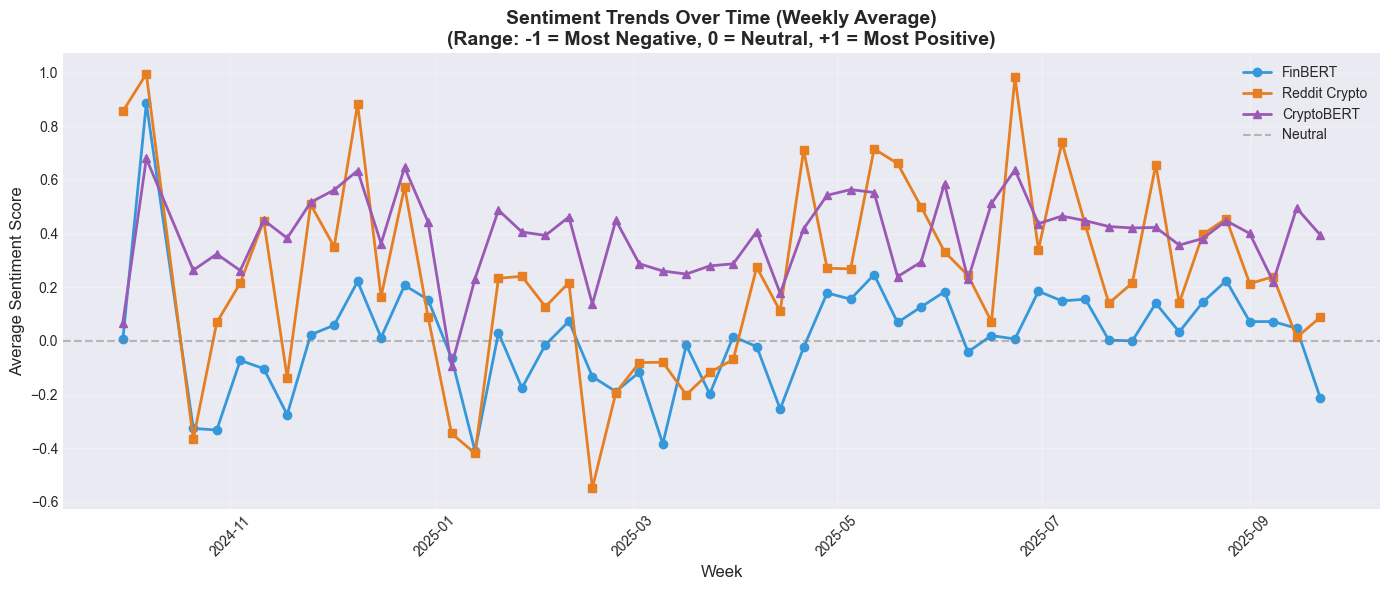

In [45]:
# Aggregate sentiment over time (weekly) using continuous scores
df["week"] = df["created_at"].dt.to_period("W").dt.to_timestamp()

weekly_sentiment = df.groupby("week").agg({
    "finbert_sentiment_score": "mean",
    "reddit_sentiment_score": "mean",
    "cryptobert_sentiment_score": "mean",
}).reset_index()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(weekly_sentiment["week"], weekly_sentiment["finbert_sentiment_score"], 
       marker="o", linewidth=2, label="FinBERT", color="#3498db")
ax.plot(weekly_sentiment["week"], weekly_sentiment["reddit_sentiment_score"], 
       marker="s", linewidth=2, label="Reddit Crypto", color="#e67e22")
ax.plot(weekly_sentiment["week"], weekly_sentiment["cryptobert_sentiment_score"], 
       marker="^", linewidth=2, label="CryptoBERT", color="#9b59b6")

ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5, label="Neutral")
ax.set_xlabel("Week", fontsize=12)
ax.set_ylabel("Average Sentiment Score", fontsize=12)
ax.set_title("Sentiment Trends Over Time (Weekly Average)\n(Range: -1 = Most Negative, 0 = Neutral, +1 = Most Positive)", 
            fontsize=14, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 7.6 Engagement Analysis


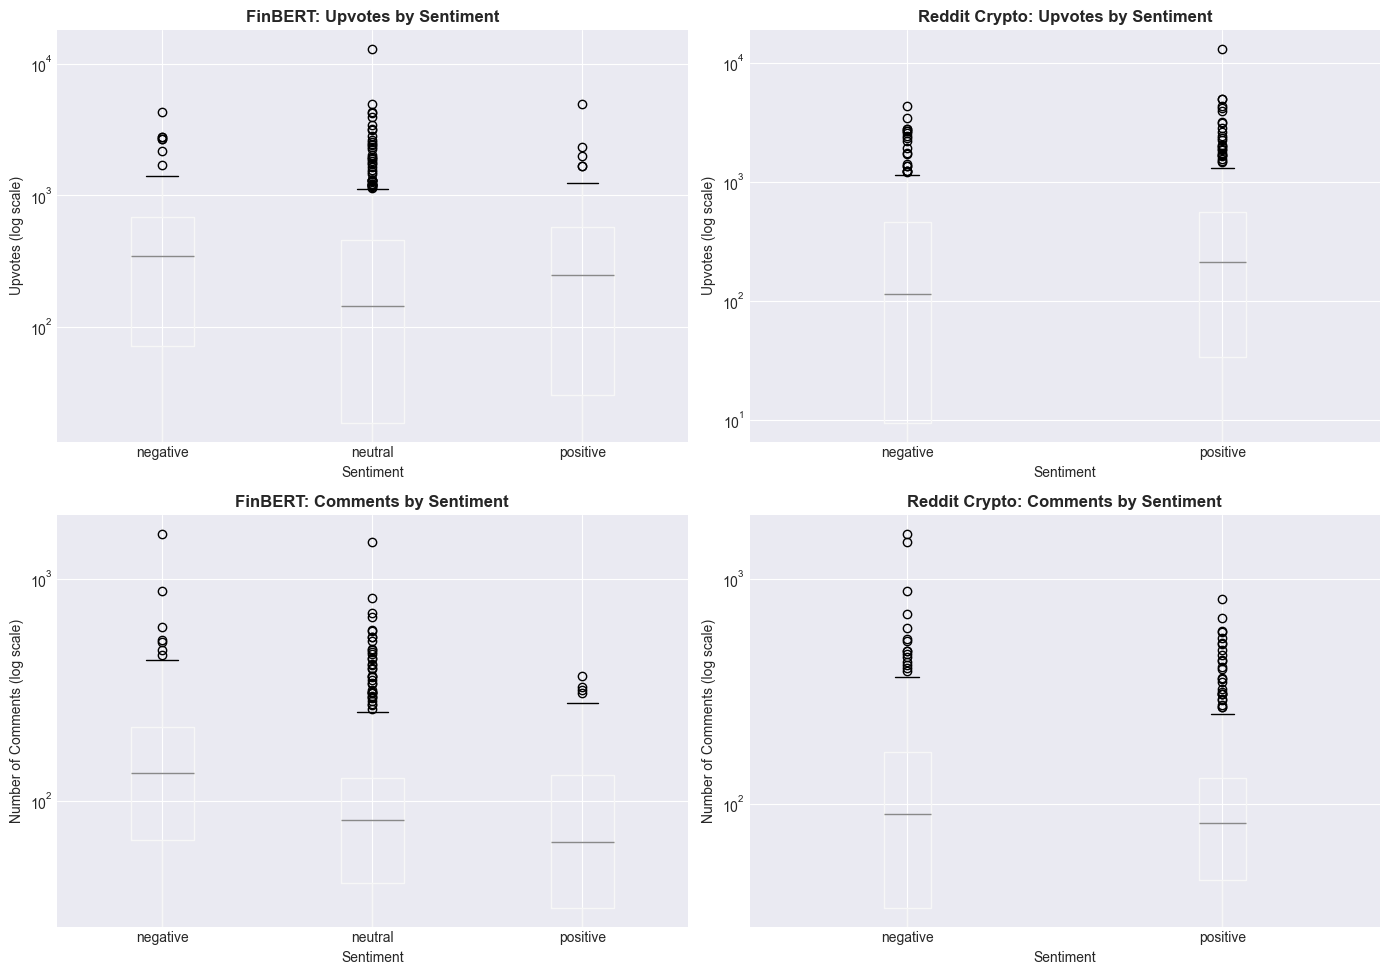


Engagement Statistics by Sentiment (FinBERT):
               upvotes  num_comments
finbert_label                       
negative         344.5         133.5
neutral          144.0          82.0
positive         247.0          65.0

Engagement Statistics by Sentiment (Reddit Crypto):
              upvotes  num_comments
reddit_label                       
negative        115.0          90.0
positive        211.0          82.0


In [46]:
# Analyze relationship between sentiment and engagement metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# FinBERT: upvotes by sentiment
df.boxplot(column="upvotes", by="finbert_label", ax=axes[0, 0])
axes[0, 0].set_title("FinBERT: Upvotes by Sentiment", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Sentiment", fontsize=10)
axes[0, 0].set_ylabel("Upvotes (log scale)", fontsize=10)
axes[0, 0].set_yscale("log")
axes[0, 0].get_figure().suptitle("")

# Reddit Crypto: upvotes by sentiment
df.boxplot(column="upvotes", by="reddit_label", ax=axes[0, 1])
axes[0, 1].set_title("Reddit Crypto: Upvotes by Sentiment", fontsize=12, fontweight="bold")
axes[0, 1].set_xlabel("Sentiment", fontsize=10)
axes[0, 1].set_ylabel("Upvotes (log scale)", fontsize=10)
axes[0, 1].set_yscale("log")
axes[0, 1].get_figure().suptitle("")

# FinBERT: comments by sentiment
df.boxplot(column="num_comments", by="finbert_label", ax=axes[1, 0])
axes[1, 0].set_title("FinBERT: Comments by Sentiment", fontsize=12, fontweight="bold")
axes[1, 0].set_xlabel("Sentiment", fontsize=10)
axes[1, 0].set_ylabel("Number of Comments (log scale)", fontsize=10)
axes[1, 0].set_yscale("log")
axes[1, 0].get_figure().suptitle("")

# Reddit Crypto: comments by sentiment
df.boxplot(column="num_comments", by="reddit_label", ax=axes[1, 1])
axes[1, 1].set_title("Reddit Crypto: Comments by Sentiment", fontsize=12, fontweight="bold")
axes[1, 1].set_xlabel("Sentiment", fontsize=10)
axes[1, 1].set_ylabel("Number of Comments (log scale)", fontsize=10)
axes[1, 1].set_yscale("log")
axes[1, 1].get_figure().suptitle("")

plt.tight_layout()
plt.show()

print("\nEngagement Statistics by Sentiment (FinBERT):") 
print(df.groupby("finbert_label")[["upvotes", "num_comments"]].median())

print("\nEngagement Statistics by Sentiment (Reddit Crypto):")
print(df.groupby("reddit_label")[["upvotes", "num_comments"]].median())


### 7.7 Sample Disagreements


In [47]:
# Show examples where models disagree
disagreements = df[~df["all_agree"]].copy()

if len(disagreements) > 0:
    print(f"Found {len(disagreements)} posts where not all models agree\n")
    
    # Sample some interesting disagreements
    sample_size = min(5, len(disagreements))
    samples = disagreements.sample(n=sample_size, random_state=42)
    
    for idx, row in samples.iterrows():
        print("=" * 80)
        print(f"\nPost {idx}:")
        print(f"Title: {row['title'][:100]}..." if len(row['title']) > 100 else f"Title: {row['title']}")
        print(f"\nFinBERT: {row['finbert_label']} (score: {row['finbert_sentiment_score']:.3f})")
        print(f"Reddit Crypto: {row['reddit_label']} (score: {row['reddit_sentiment_score']:.3f})")
        print(f"CryptoBERT: {row['cryptobert_label']} (score: {row['cryptobert_sentiment_score']:.3f})")
        print(f"\nUpvotes: {row['upvotes']}, Comments: {row['num_comments']}")
        print()
else:
    print("All models agree on all posts!")


Found 595 posts where not all models agree


Post 216:
Title: Everyone is ignoring ETH, that might be a huge mistake.

FinBERT: negative (score: -0.460)
Reddit Crypto: negative (score: -0.989)
CryptoBERT: neutral (score: 0.458)

Upvotes: 263, Comments: 135


Post 270:
Title: Ethereum down 33% since Eric Trump suggested it was a 'great time' to buy

FinBERT: negative (score: -0.956)
Reddit Crypto: negative (score: -0.208)
CryptoBERT: neutral (score: 0.138)

Upvotes: 2677, Comments: 298


Post 530:
Title: ETH bull run

FinBERT: neutral (score: 0.031)
Reddit Crypto: positive (score: 0.997)
CryptoBERT: positive (score: 0.564)

Upvotes: 65, Comments: 102


Post 533:
Title: Is it time for me to swap my ETH to BTC?

FinBERT: neutral (score: -0.054)
Reddit Crypto: positive (score: 0.208)
CryptoBERT: positive (score: 0.474)

Upvotes: 23, Comments: 92


Post 209:
Title: BlackRock just transferred 18168 ETH to Coinbase! What’s going on??

FinBERT: neutral (score: -0.190)
Reddit Crypto: negative (

## 8. Summary Statistics


In [48]:
print("=" * 80)
print("SENTIMENT ANALYSIS COMPARISON SUMMARY (3 MODELS)")
print("=" * 80)

print(f"\nDataset: {len(df):,} Ethereum Reddit posts")
print(f"Date range: {df['created_at'].min()} to {df['created_at'].max()}")

print("\n" + "=" * 80)
print("MODEL AGREEMENT")
print("=" * 80)
print(f"FinBERT ↔ Reddit Crypto: {df['finbert_reddit_agree'].mean():.2%}")
print(f"FinBERT ↔ CryptoBERT: {df['finbert_cryptobert_agree'].mean():.2%}")
print(f"Reddit Crypto ↔ CryptoBERT: {df['reddit_cryptobert_agree'].mean():.2%}")
print(f"All 3 models agree: {df['all_agree'].mean():.2%} ({df['all_agree'].sum():,} posts)")

print("\n" + "=" * 80)
print("SENTIMENT DISTRIBUTIONS")
print("=" * 80)

print("\nFinBERT:")
for sentiment in ["positive", "neutral", "negative"]:
    count = (df["finbert_label"] == sentiment).sum()
    pct = count / len(df) * 100
    print(f"  {sentiment.capitalize()}: {count:,} ({pct:.1f}%)")

print("\nReddit Crypto Model:")
for sentiment in ["positive", "neutral", "negative"]:
    count = (df["reddit_label"] == sentiment).sum()
    pct = count / len(df) * 100
    print(f"  {sentiment.capitalize()}: {count:,} ({pct:.1f}%)")

print("\nCryptoBERT:")
for sentiment in ["positive", "neutral", "negative"]:
    count = (df["cryptobert_label"] == sentiment).sum()
    pct = count / len(df) * 100
    print(f"  {sentiment.capitalize()}: {count:,} ({pct:.1f}%)")

print("\n" + "=" * 80)
print("CONFIDENCE SCORES")
print("=" * 80)
print(f"\nFinBERT:")
print(f"  Mean: {df['finbert_confidence'].mean():.4f}")
print(f"  Median: {df['finbert_confidence'].median():.4f}")
print(f"  Std: {df['finbert_confidence'].std():.4f}")

print(f"\nReddit Crypto:")
print(f"  Mean: {df['reddit_confidence'].mean():.4f}")
print(f"  Median: {df['reddit_confidence'].median():.4f}")
print(f"  Std: {df['reddit_confidence'].std():.4f}")

print(f"\nCryptoBERT:")
print(f"  Mean: {df['cryptobert_confidence'].mean():.4f}")
print(f"  Median: {df['cryptobert_confidence'].median():.4f}")
print(f"  Std: {df['cryptobert_confidence'].std():.4f}")

print("\n" + "=" * 80)
print("CONTINUOUS SENTIMENT SCORES (-1 to +1)")
print("=" * 80)
print(f"\nFinBERT:")
print(f"  Mean: {df['finbert_sentiment_score'].mean():.4f}")
print(f"  Median: {df['finbert_sentiment_score'].median():.4f}")
print(f"  Std: {df['finbert_sentiment_score'].std():.4f}")

print(f"\nReddit Crypto:")
print(f"  Mean: {df['reddit_sentiment_score'].mean():.4f}")
print(f"  Median: {df['reddit_sentiment_score'].median():.4f}")
print(f"  Std: {df['reddit_sentiment_score'].std():.4f}")

print(f"\nCryptoBERT:")
print(f"  Mean: {df['cryptobert_sentiment_score'].mean():.4f}")
print(f"  Median: {df['cryptobert_sentiment_score'].median():.4f}")
print(f"  Std: {df['cryptobert_sentiment_score'].std():.4f}")

print("\n(Scale: -1 = most negative, 0 = neutral, +1 = most positive)")

print("\n" + "=" * 80)


SENTIMENT ANALYSIS COMPARISON SUMMARY (3 MODELS)

Dataset: 668 Ethereum Reddit posts
Date range: 2024-10-06 12:35:49 to 2025-09-28 19:29:05

MODEL AGREEMENT
FinBERT ↔ Reddit Crypto: 23.35%
FinBERT ↔ CryptoBERT: 42.66%
Reddit Crypto ↔ CryptoBERT: 42.07%
All 3 models agree: 10.93% (73 posts)

SENTIMENT DISTRIBUTIONS

FinBERT:
  Positive: 85 (12.7%)
  Neutral: 499 (74.7%)
  Negative: 84 (12.6%)

Reddit Crypto Model:
  Positive: 417 (62.4%)
  Neutral: 0 (0.0%)
  Negative: 251 (37.6%)

CryptoBERT:
  Positive: 344 (51.5%)
  Neutral: 274 (41.0%)
  Negative: 50 (7.5%)

CONFIDENCE SCORES

FinBERT:
  Mean: 0.8182
  Median: 0.8705
  Std: 0.1303

Reddit Crypto:
  Mean: 0.9456
  Median: 0.9937
  Std: 0.1099

CryptoBERT:
  Mean: 0.6362
  Median: 0.6188
  Std: 0.1131

CONTINUOUS SENTIMENT SCORES (-1 to +1)

FinBERT:
  Mean: 0.0211
  Median: 0.0321
  Std: 0.4016

Reddit Crypto:
  Mean: 0.2373
  Median: 0.9156
  Std: 0.8873

CryptoBERT:
  Mean: 0.3981
  Median: 0.4890
  Std: 0.3573

(Scale: -1 = most n